# Resources used

In [1]:
import time
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import yellowbrick
from yellowbrick.model_selection import LearningCurve
from datetime import datetime

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, GridSearchCV, ParameterGrid

import sklearn
import xgboost as xgb
#from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from tqdm.notebook import trange

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE

In [2]:
print(f"shap: v {shap.__version__}")
print(f"numpy: v {np.__version__}")
print(f"pandas: v {pd.__version__}")
print(f"seaborn: v {sns.__version__}")
print(f"matplotlib: v {matplotlib.__version__}")
print(f"yellowbrick: v {yellowbrick.__version__}")
print(f"sklearn: v {sklearn.__version__}")
print(f"XGBoost: v {xgb.__version__}")

plt.rcParams['font.family'] = 'Palatino Linotype'
plt.rcParams['font.size'] = 12
random_state=42

shap: v 0.47.0
numpy: v 1.25.2
pandas: v 2.2.3
seaborn: v 0.13.2
matplotlib: v 3.6.2
yellowbrick: v 1.5
sklearn: v 1.4.2
XGBoost: v 2.1.2


# Exploratory data analisys

## Data collection

In [3]:
df = pd.read_csv('数据时间导出.csv')  # 47 features
df = df.rename(columns={'VD0000':'impl_spd2',  # Main fan speed [rps]
                        'VD0008':'pump_spd',  # Peristaltic pump rotation speed [rps]
                        'VD0012':'I',  # Current [A]
                        'VD0016':'V',  # Voltage [V]
                        'VD0020':'W',  # Power [Wt]
                        'VD0028':'Q_CH4',  # CH4 flow rate [m3/h]
                        'VD0032':'impl_spd1',  # Cooling fan speed [rps]
                        'VD0036':'Q_CH4_N2',  #CH4/N2 flow rate [m3/h]
                        'VD0040':'P_NG',  # Differential natural gas pressure [bar]
                        'VD44':'O2',  # Inlet air oxygen concentration [%]
                        'VD208':'T3',  # bottom of the burner temperature [°C]
                        'VD212':'T4',  # top of the burner temperature [°C]
                        'VD216':'T5',  # inlet of the reformer temperature [°C]
                        'VD224':'T7',  # exhaust gases from the SOFC temperature [°C]
                        'VD232':'T9',  # heat exchanger temperature [°C]
                        'VD244':'T12',  # water temperature for steam reforming [°C]
                        'VD260':'T16',  # left front point of the SOFC temperature [°C]
                        'VD264':'T17',  # right rear point of the SOFC temperature [°C]
                        'VD272':'T19',  # air at the inlet of the SOFC temperature [°C]
                        'VD276':'T20',  # hydrogen at the inlet of the SOFC temperature [°C]
                        'VD280':'T21',  # air at the outlet of the SOFC temperature [°C]
                        'VD284':'T22',  # hydrogen at the outlet of the SOFC temperature [°C]
                        'VD288':'T23',  # top rear point of the reformer temperature [°C]
                        'VD292':'T24',  # bottom rear point of the reformer temperature [°C]
                        'VD296':'T25',  # top left point of the reformer temperature [°C]
                        'VD300':'T26',  # bottom left point of the reformer temperature [°C]
                        'VD304':'T27',  # top right point of the reformer temperature [°C]
                        'VD308':'T28',  # bottom right point of the reformer temperature [°C]
                        'VD316':'T30',  # cooling water temperature [°C]
                        'VD320':'T31'})  # water tank temperature [°C]

df.MCGS_TIME = pd.to_datetime(df.MCGS_TIME)
df = df.set_index('MCGS_TIME')
df = df.drop(columns=['MCGS_TIMEMS', 'VD48', 'VD0004', 'VD0024'])  # drop 4 useless features
df = df[df.columns[(abs(df.mean()-3000)>0.1)]]  # filtering 12 incorrect sensor readings
df = df[df.T17 != 3000]  # remove 92 lines with incorrect T17-value
df = df[df.V != 0]  # remove 18324 lines with zero target feature

# combine similar features (-4)
df.T3 = df[['T3', 'T4']].mean(axis=1)
df.T23 = df[['T23', 'T24']].mean(axis=1)
df.T25 = df[['T25', 'T26']].mean(axis=1)
df.T27 = df[['T27', 'T28']].mean(axis=1)
df = df.drop(columns=['T4', 'T24', 'T26', 'T28'])

# move the voltage to the end position (for correlation matrix)
V = df.V
df = df.drop('V', axis=1)
df['V'] = V

#df.to_excel(f'DATA.xlsx')

print(df.info())
df.iloc[5480:5490, :]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14427 entries, 2024-04-23 19:20:09 to 2025-02-14 22:20:00
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   impl_spd2  14427 non-null  float64
 1   I          14427 non-null  float64
 2   pump_spd   14427 non-null  float64
 3   W          14427 non-null  float64
 4   Q_CH4      14427 non-null  float64
 5   impl_spd1  14427 non-null  float64
 6   Q_CH4_N2   14427 non-null  float64
 7   P_NG       14427 non-null  float64
 8   T3         14427 non-null  float64
 9   T5         14427 non-null  float64
 10  T7         14427 non-null  float64
 11  T9         14427 non-null  float64
 12  T12        14427 non-null  float64
 13  T16        14427 non-null  float64
 14  T17        14427 non-null  float64
 15  T19        14427 non-null  float64
 16  T20        14427 non-null  float64
 17  T21        14427 non-null  float64
 18  T22        14427 non-null  float64
 19  T23        

,impl_spd2,I,pump_spd,W,Q_CH4,impl_spd1,Q_CH4_N2,P_NG,T3,T5,...,T20,T21,T22,T23,T25,T27,T30,T31,O2,V
MCGS_TIME,,,,,,,,,,,,,,,,,,,,,
2024-04-25 17:09:57,11.000004,0.00,20.0,0.000,1.915943,6.0,5.971296,0.012215,874.949982,552.900024,...,667.599976,684.299988,618.700012,569.799988,630.149994,677.850006,66.199997,52.599998,12.0000,40.500000
2024-04-25 17:10:27,11.000004,0.03,20.0,1.218,1.797853,6.0,5.969877,0.012210,888.649994,552.799988,...,668.099976,684.299988,618.599976,570.349976,632.100006,682.500000,66.099998,52.599998,10.9375,40.599998
2024-04-25 17:10:57,11.000004,0.03,20.0,1.221,0.000099,6.0,6.114091,0.013080,829.799988,552.799988,...,668.900024,684.299988,618.599976,570.750000,634.450012,686.800018,66.000000,52.599998,11.0000,40.700001
2024-04-25 17:11:27,11.000004,0.03,20.0,1.218,0.000099,6.0,6.180676,0.013943,791.750000,552.799988,...,669.599976,684.299988,618.599976,570.899994,636.500000,688.549988,66.000000,52.599998,12.8125,40.599998
2024-04-25 17:11:57,11.000004,0.03,20.0,1.212,0.000099,6.0,5.873411,0.013312,780.850006,552.799988,...,670.299988,684.299988,618.700012,570.950012,637.199982,688.299988,66.000000,52.599998,13.4375,40.400002
2024-04-25 17:12:27,11.000004,0.03,20.0,1.218,0.000099,6.0,6.007771,0.013530,774.299988,552.799988,...,670.700012,684.299988,618.799988,570.750000,637.299988,687.399994,65.900002,52.599998,13.7500,40.599998
2024-04-25 17:12:57,11.000004,0.03,20.0,1.215,0.000099,6.0,5.960526,0.013125,771.300018,552.900024,...,670.900024,684.299988,619.000000,570.750000,636.950012,686.350006,65.900002,52.599998,13.8750,40.500000
2024-04-25 17:13:27,11.000004,0.03,20.0,1.215,0.000099,6.0,6.058997,0.013146,769.399994,552.799988,...,670.900024,684.299988,619.099976,570.549988,636.449982,685.350006,65.900002,52.500000,14.0000,40.500000
2024-04-25 17:13:57,11.000004,0.03,20.0,1.080,0.000099,6.0,5.957923,0.013148,766.700012,552.799988,...,670.900024,684.299988,619.299988,570.450012,635.899994,684.549988,65.900002,52.500000,14.0000,36.000000


## Correlation matrix of initial features

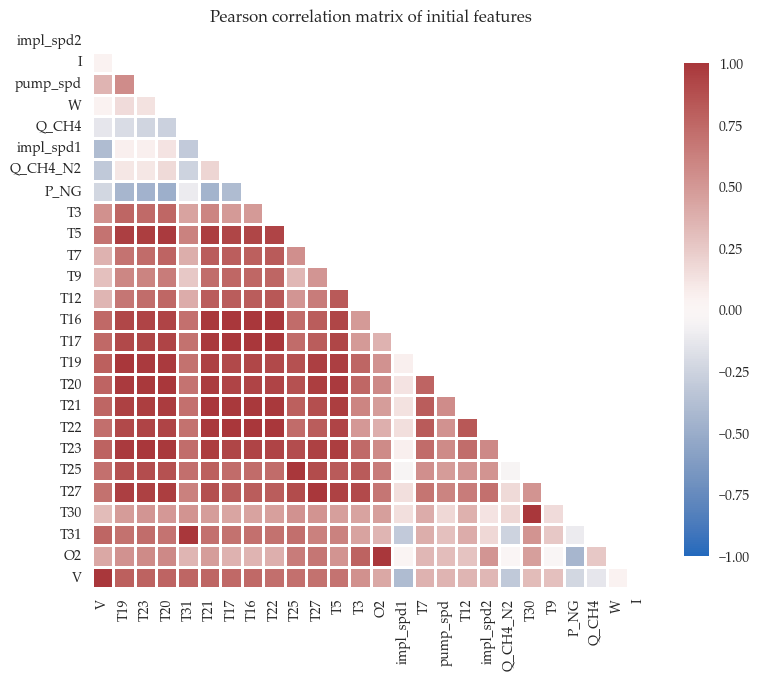

In [4]:
df_corr = df.corr('pearson')

# Let's sort column B by correlation strength (absolute value)
df_corr.sort_values(by='V', axis='columns', ascending=False, inplace=True, key=lambda col: abs(col))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df_corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(9, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_corr, 
            #annot=True, 
            mask=mask, 
            cmap=sns.color_palette("vlag", as_cmap=True), 
            fmt=".3f", 
            vmax=1.0, 
            vmin=-1.0, 
            center=0,
            square=True, 
            linewidths=1, 
            cbar_kws={"shrink": .8}).set(title='Pearson correlation matrix of initial features')

plt.savefig('pictures/full_corr_matrix.png', dpi = 300, transparent = True)
#df_corr.style.background_gradient(cmap=sns.color_palette("vlag", as_cmap=True), vmin = -1, vmax=1)  # output table-factor

## Data preprocessing

In [5]:
X = df.drop(columns='V').copy()  # input feature
y = df.V.copy()  # target feature (Voltage [V])

# Standardization of input feature general set 
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_std = pd.DataFrame(X_std, columns=X.columns)

# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=random_state)

## Feature important

### XGBoost features importance (MDI)

In [6]:
n = 11  # base component count

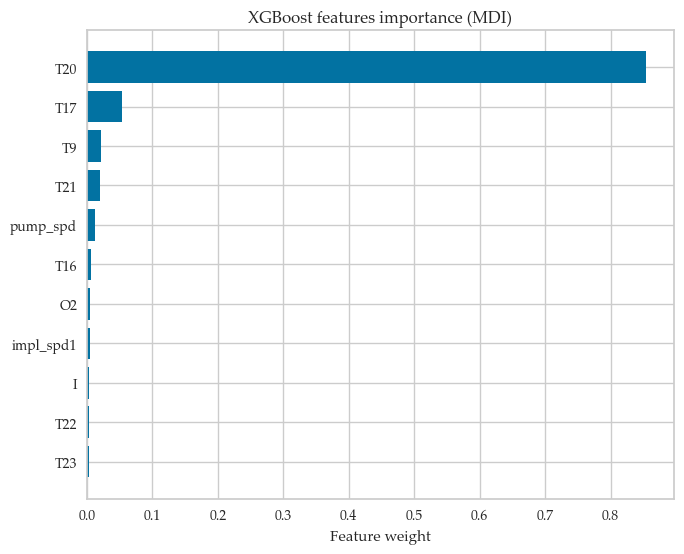

In [7]:
selector = xgb.XGBRegressor(random_state=random_state)
selector.fit(X_std, y)

feature_importances = pd.DataFrame({'importance' : selector.feature_importances_}, 
                                   index=X_std.columns).sort_values(by='importance', ascending=True)

feature_importances = feature_importances.iloc[-n:, :]  # get n-strongest features
MDI_columns = feature_importances.sort_values(by='importance', ascending=False).index

plt.figure(figsize=(7, n/2))
plt.barh(range(len(feature_importances.index)), feature_importances.importance, align='center')
plt.yticks(range(len(feature_importances.index)), feature_importances.index)
plt.xlabel('Feature weight')
plt.tight_layout()
plt.savefig('pictures/standard_feature_important.png', dpi = 300, transparent = True)
plt.title('XGBoost features importance (MDI)')
plt.show()

### Permutation Importance (PI)

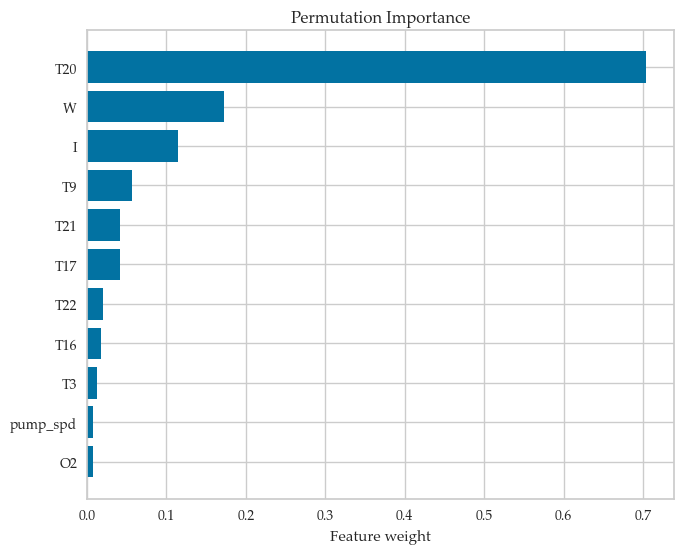

In [8]:
feature_importances = pd.DataFrame(
    {'importance' : permutation_importance(selector, X_std, y, n_repeats=5, 
                                           random_state=random_state, n_jobs=-1).importances_mean},
    index=X_std.columns).sort_values(by='importance', ascending=True)

feature_importances = feature_importances.iloc[-n:, :]  # get n-strongest features
PI_columns = feature_importances.sort_values(by='importance', ascending=False).index

plt.figure(figsize=(7, n/2))
plt.barh(range(len(feature_importances.index)), feature_importances.importance, align='center')
plt.yticks(range(len(feature_importances.index)), feature_importances.index)
plt.xlabel('Feature weight')
plt.tight_layout()
plt.savefig('pictures/Permutation_Importance.png', dpi = 300, transparent = True)
plt.title('Permutation Importance')
plt.show()

### SHapley Additive exPlanations (SHAP)

In [9]:
def global_shap_importance(model, X):
    """ Return a dataframe containing the features sorted by Shap importance
    Parameters
    ----------
    model : The tree-based model 
    X : pd.Dataframe
         training set/test set/the whole dataset ... (without the label)
    Returns
    -------
    pd.Dataframe
        A dataframe containing the features sorted by Shap importance
    """
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    cohorts = {"": shap_values}
    cohort_labels = list(cohorts.keys())
    cohort_exps = list(cohorts.values())
    for i in range(len(cohort_exps)):
        if len(cohort_exps[i].shape) == 2:
            cohort_exps[i] = cohort_exps[i].abs.mean(0)
    features = cohort_exps[0].data
    feature_names = cohort_exps[0].feature_names
    values = np.array([cohort_exps[i].values for i in range(len(cohort_exps))])
    feature_importance = pd.DataFrame(
        list(zip(feature_names, sum(values))), columns=['features', 'importance'])
    feature_importance.sort_values(by=['importance'], ascending=False, inplace=True)
    return feature_importance.set_index('features')

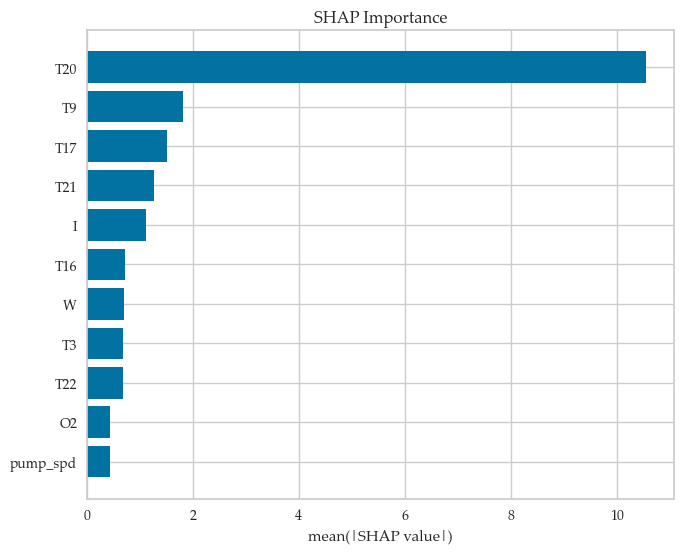

In [10]:
feature_importances = global_shap_importance(selector, X_std).iloc[:n, :]  # get n-strongest feature
SHAP_columns = feature_importances.index

feature_importances.sort_values(by=['importance'], ascending=True, inplace=True)
plt.figure(figsize=(7, n/2))
plt.barh(range(len(feature_importances.index)), feature_importances.importance, align='center')
plt.yticks(range(len(feature_importances.index)), feature_importances.index)
plt.xlabel('mean(|SHAP value|)')
plt.tight_layout()
plt.savefig('pictures/SHAP_Importance2.png', dpi = 300, transparent = True)
plt.title('SHAP Importance')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

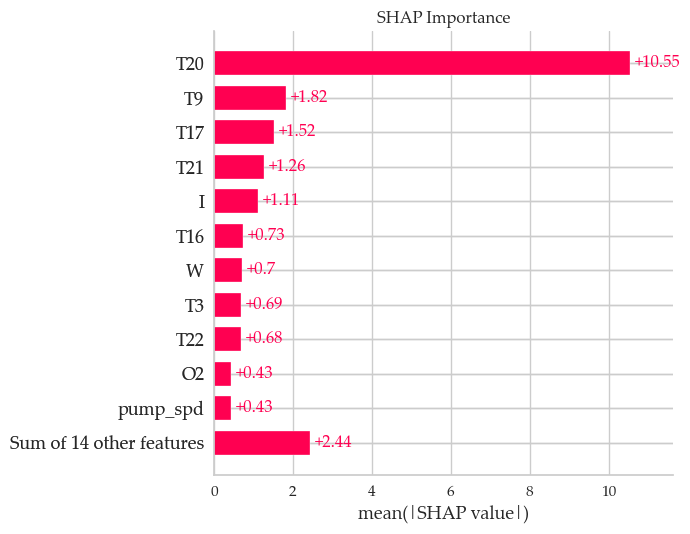

In [11]:
explainer = shap.Explainer(selector)
shap_importances = explainer(X_std)

shap.plots.bar(shap_importances, max_display=n+1, show=False)

plt.gcf().set_size_inches(7, n/2)
plt.title('SHAP Importance')
plt.tight_layout()
plt.savefig('pictures/SHAP_Importance.png', dpi = 300, transparent = True)
plt.show

###	Principal component analysis (PCA)

In [12]:
# Features PCA decomposition
n = 5  # number strongest features
pca = PCA(n_components=n)
pca.fit(X_std)
X_dec = pca.fit_transform(X_std)
X_dec = pd.DataFrame(X_dec, columns=[f'component{i}' for i in range(n)])

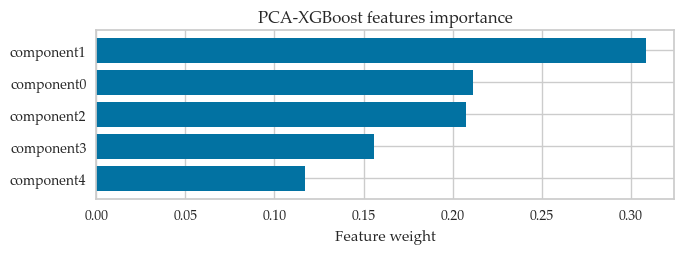

,importance
component4,0.116895
component3,0.155628
component2,0.207408
component0,0.211287
component1,0.308782


In [13]:
selector = xgb.XGBRegressor(objective='reg:absoluteerror', random_state=random_state)
selector.fit(X_dec, y)

feature_importances = pd.DataFrame({'importance' : selector.feature_importances_}, 
                                   index=X_dec.columns).sort_values(by='importance', ascending=True)

plt.figure(figsize=(7, n/2))
plt.barh(range(len(feature_importances.index)), feature_importances.importance, align='center')
plt.yticks(range(len(feature_importances.index)), feature_importances.index)
plt.xlabel('Feature weight')
plt.tight_layout()
plt.savefig('pictures/PCA-Decomposed_feature_important.png', dpi = 300, transparent = True)
plt.title('PCA-XGBoost features importance')
plt.show()

feature_importances

# Fit models

In [14]:
# dataFrame with search result
search_result = pd.DataFrame(columns=['R2_score', 'MSE', 'MAE', 'MAPE', 'seconds'])

## XGBoost

In [15]:
# XGBoost GridSearchCV option

n_splits=5

param_grid={'max_depth': range(2, 6),
            'learning_rate': [0.01, 0.1, 0.2],
            'gamma': [0, 0.1, 1, 10],
            #'min_child_weight': [0, 0.1, 1, 10]
           }

### default (full set)

In [16]:
%%time

start_time = time.time()
XGB_grid = GridSearchCV(estimator=xgb.XGBRegressor(random_state=random_state),
                        param_grid=param_grid, 
                        verbose=1,
                        #cv=ShuffleSplit(n_splits=n_splits, random_state=random_state),
                        cv=n_splits
                        )

XGB_grid.fit(X_train, y_train)
XGB_best = XGB_grid.best_estimator_
y_pred = XGB_best.predict(X_test)

elapsed_time = time.time() - start_time

print("Best XGBRegressor-params:", XGB_grid.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best XGBRegressor-params: {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5}
CPU times: total: 5min 23s
Wall time: 42.2 s


In [17]:
search_result.loc['XGB default'] = (r2_score(y_pred, y_test),
                                    MSE(y_pred, y_test),
                                    MAE(y_pred, y_test),
                                    MAPE(y_pred, y_test),
                                    elapsed_time/(len(ParameterGrid(param_grid))*n_splits))
print('default XGBoost',
      f'r2_score: {r2_score(y_pred, y_test):.4}',
      f'MSE: {MSE(y_pred, y_test):.4}',
      f'MAE: {MAE(y_pred, y_test):.4}',
      f'MAPE: {MAPE(y_pred, y_test):.2%}', sep='\n')

default XGBoost
r2_score: 0.997
MSE: 0.994
MAE: 0.3086
MAPE: 2.63%


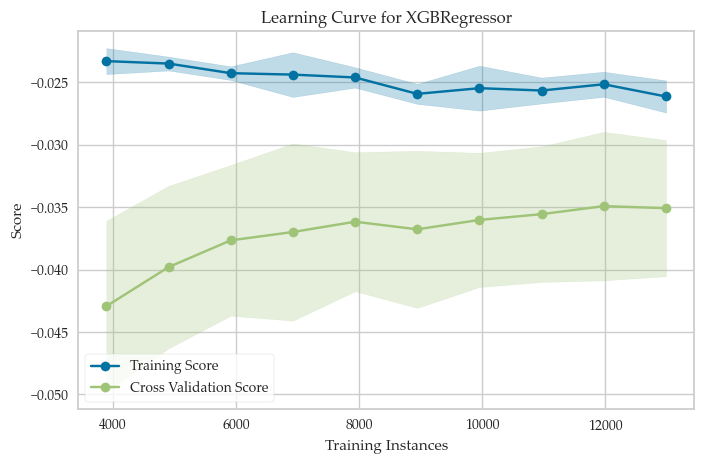

<AxesSubplot: title={'center': 'Learning Curve for XGBRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [18]:
# Plotting learning curve for XGBoost regressor
cv = ShuffleSplit(n_splits=5, random_state=random_state)
sizes = np.linspace(0.3, 1.0, 10)
plt.figure(figsize=(8,6))
visualizer = LearningCurve(XGB_best, 
                           cv=cv, 
                           scoring='neg_mean_absolute_percentage_error', 
                           train_sizes=sizes, n_jobs=-1, size=(720, 480))

visualizer.fit(X_std,y)

plt.title('Learning Curve for XGBRegressor')
plt.xlabel('Training Instances')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.savefig('pictures/Learning_Curve_for_XGBR.png', dpi = 300, transparent = True)
visualizer.show()

### PCA

In [19]:
%%time

start_time = time.time()
df_PCA_XGB_search = pd.DataFrame(columns=['r2_score', 'MSE', 'MAE', 'MAPE'])

for n in trange(5, X_train.shape[1], 2, desc=f"components progress"):
    pca = PCA(n_components=n)
    pca.fit(X_std)
    X_dec = pca.fit_transform(X_std)
    X_dec = pd.DataFrame(X_dec, columns=[f'component{i}' for i in range(n)])

    X_dec_train2, X_dec_test2, y_train, y_test = train_test_split(X_dec, y, test_size=0.2, random_state=random_state)
    
    XGB_grid = GridSearchCV(estimator=xgb.XGBRegressor(random_state=random_state),
                            param_grid=param_grid, 
                            verbose=0,
                            cv=ShuffleSplit(n_splits=n_splits, random_state=random_state),
                            #cv=n_splits
                            )

    XGB_grid.fit(X_dec_train2, y_train)
    print(f"Best XGBRegressor-params for {n} components", XGB_grid.best_params_)
    
    XGB_best = XGB_grid.best_estimator_
    y_pred = XGB_best.predict(X_dec_test2)
    
    df_PCA_XGB_search.loc[n] = (r2_score(y_pred, y_test),
                                MSE(y_pred, y_test), 
                                MAE(y_pred, y_test),
                                MAPE(y_pred, y_test))

elapsed_time = time.time() - start_time

n = df_PCA_XGB_search.MAPE.idxmin()  # get optimal count component

components progress:   0%|          | 0/10 [00:00<?, ?it/s]

Best XGBRegressor-params for 5 components {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5}
Best XGBRegressor-params for 7 components {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5}
Best XGBRegressor-params for 9 components {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5}
Best XGBRegressor-params for 11 components {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5}
Best XGBRegressor-params for 13 components {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5}
Best XGBRegressor-params for 15 components {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5}
Best XGBRegressor-params for 17 components {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5}
Best XGBRegressor-params for 19 components {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5}
Best XGBRegressor-params for 21 components {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5}
Best XGBRegressor-params for 23 components {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5}
CPU times: total: 43min 22s
Wall time: 5min 38s


In [20]:
search_result.loc[f'XGB+PCA({n})'] = (df_PCA_XGB_search.loc[n].r2_score,
                                      df_PCA_XGB_search.loc[n].MSE,
                                      df_PCA_XGB_search.loc[n].MAE,
                                      df_PCA_XGB_search.loc[n].MAPE,
                                      elapsed_time/(len(ParameterGrid(param_grid))*
                                                    n_splits*(len(range(5, X_train.shape[1], 2)))))
print(f'PCA {n} components',
      f'r2_score: {df_PCA_XGB_search.loc[n].r2_score:.4}',
      f'MSE: {df_PCA_XGB_search.loc[n].MSE:.4}',
      f'MAE: {df_PCA_XGB_search.loc[n].MAE:.4}',
      f'MAPE: {df_PCA_XGB_search.loc[n].MAPE:.2%}', sep='\n')

PCA 19 components
r2_score: 0.9952
MSE: 1.567
MAE: 0.3923
MAPE: 3.52%


In [21]:
df_PCA_XGB_search

,r2_score,MSE,MAE,MAPE
5,0.994621,1.767363,0.465450,0.046790
7,0.994839,1.697395,0.438937,0.081581
9,0.994547,1.794333,0.433339,0.051183
11,0.994759,1.721933,0.411244,0.039395
13,0.995036,1.634615,0.403667,0.206466
15,0.995026,1.638480,0.391235,0.050930
17,0.995316,1.539563,0.382517,0.035885
19,0.995236,1.566997,0.392298,0.035152
21,0.995199,1.582588,0.375544,0.044173
23,0.995308,1.546904,0.372160,0.093174


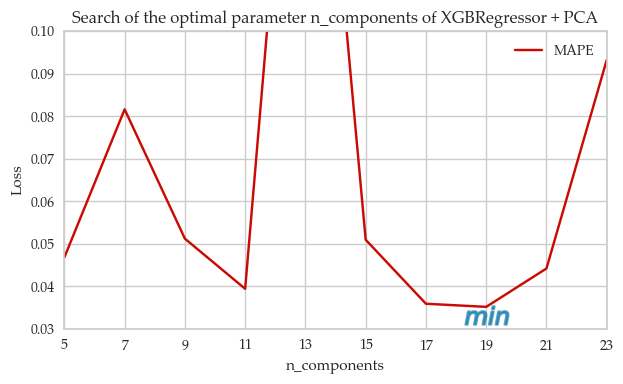

In [22]:
# plot search of the optimal parameter n_components of PCA
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
#plt.plot(df_PCA_XGB_search.index, df_PCA_XGB_search.MAE, 'b', label='MAE')
plt.plot(df_PCA_XGB_search.index, df_PCA_XGB_search.MAPE, 'r', label='MAPE')
plt.xlabel('n_components')
plt.xlim(left=5, right=23)
plt.xticks(ticks=np.arange(5, X_train.shape[1], step=2))
plt.ylabel('Loss')
plt.ylim(0.03, 0.1)
plt.legend()
plt.title('Search of the optimal parameter n_components of XGBRegressor + PCA')

plt.scatter(df_PCA_XGB_search.MAPE.idxmin(), 
            df_PCA_XGB_search.MAPE.min()-0.002,
            linewidth=1.5,
            marker='$min$',
            alpha=0.6,
            s=1000)

plt.tight_layout()
plt.savefig('pictures/PCA_XGB_search.png', dpi = 300, transparent = True)
plt.show()

### SHAP

In [23]:
%%time

n = 11  # base component count

X_train3 = X_train[SHAP_columns[:n]]
X_test3 = X_test[SHAP_columns[:n]]

start_time = time.time()
XGB_grid = GridSearchCV(estimator=xgb.XGBRegressor(random_state=random_state),
                        param_grid=param_grid,
                        verbose=0,
                        cv=ShuffleSplit(n_splits=n_splits, random_state=random_state),
                        #cv=n_splits
                        )

XGB_grid.fit(X_train3, y_train)
XGB_best = XGB_grid.best_estimator_
y_pred = XGB_best.predict(X_test3)

elapsed_time = time.time() - start_time

print("Best XGBRegressor-params:", XGB_grid.best_params_)

Best XGBRegressor-params: {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5}
CPU times: total: 3min 20s
Wall time: 26 s


In [24]:
search_result.loc[f'XGB+SHAP({X_train3.shape[1]})'] = (r2_score(y_pred, y_test),
                                                       MSE(y_pred, y_test),
                                                       MAE(y_pred, y_test),
                                                       MAPE(y_pred, y_test),
                                                       elapsed_time/(len(ParameterGrid(param_grid))*n_splits))
print(f'SHAP {X_train3.shape[1]} feature',
      f'r2_score: {r2_score(y_pred, y_test):.4}',
      f'MSE: {MSE(y_pred, y_test):.4}',
      f'MAE: {MAE(y_pred, y_test):.4}',
      f'MAPE: {MAPE(y_pred, y_test):.2%}', sep='\n')

SHAP 11 feature
r2_score: 0.9966
MSE: 1.118
MAE: 0.3834
MAPE: 3.40%


### PI

In [25]:
%%time

X_train4 = X_train[PI_columns[:n]]
X_test4 = X_test[PI_columns[:n]]

start_time = time.time()
XGB_grid = GridSearchCV(estimator=xgb.XGBRegressor(random_state=random_state),
                        param_grid=param_grid,
                        verbose=1,
                        cv=ShuffleSplit(n_splits=n_splits, random_state=random_state),
                        #cv=n_splits
                        )

XGB_grid.fit(X_train4, y_train)
XGB_best = XGB_grid.best_estimator_
y_pred = XGB_best.predict(X_test4)

elapsed_time = time.time() - start_time

print("Best XGBRegressor-params:", XGB_grid.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best XGBRegressor-params: {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5}
CPU times: total: 3min 21s
Wall time: 26.1 s


In [26]:
search_result.loc[f'XGB+PI({X_train4.shape[1]})'] = (r2_score(y_pred, y_test),
                                                    MSE(y_pred, y_test),
                                                    MAE(y_pred, y_test),
                                                    MAPE(y_pred, y_test),
                                                    elapsed_time/(len(ParameterGrid(param_grid))*n_splits))
print(f'PI {X_train4.shape[1]} feature',
      f'r2_score: {r2_score(y_pred, y_test):.4}',
      f'MSE: {MSE(y_pred, y_test):.4}',
      f'MAE: {MAE(y_pred, y_test):.4}',
      f'MAPE: {MAPE(y_pred, y_test):.2%}', sep='\n')

PI 11 feature
r2_score: 0.9966
MSE: 1.123
MAE: 0.3841
MAPE: 3.40%


### MDI

In [27]:
%%time

X_train5 = X_train[MDI_columns[:n]]
X_test5 = X_test[MDI_columns[:n]]

start_time = time.time()
XGB_grid = GridSearchCV(estimator=xgb.XGBRegressor(random_state=random_state),
                        param_grid=param_grid,
                        verbose=0,
                        cv=ShuffleSplit(n_splits=n_splits, random_state=random_state),
                        #cv=n_splits
                        )

XGB_grid.fit(X_train5, y_train)
XGB_best = XGB_grid.best_estimator_
y_pred = XGB_best.predict(X_test5)

elapsed_time = time.time() - start_time

print("Best XGBRegressor-params:", XGB_grid.best_params_)

Best XGBRegressor-params: {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5}
CPU times: total: 3min 20s
Wall time: 26 s


In [28]:
search_result.loc[f'XGB+MDI({X_train5.shape[1]})'] = (r2_score(y_pred, y_test),
                                                      MSE(y_pred, y_test),
                                                      MAE(y_pred, y_test),
                                                      MAPE(y_pred, y_test),
                                                      elapsed_time/(len(ParameterGrid(param_grid))*n_splits))
print(f'MDI {X_train5.shape[1]} feature',
      f'r2_score: {r2_score(y_pred, y_test):.4}',
      f'MSE: {MSE(y_pred, y_test):.4}',
      f'MAE: {MAE(y_pred, y_test):.4}',
      f'MAPE: {MAPE(y_pred, y_test):.2%}', sep='\n')

MDI 11 feature
r2_score: 0.9956
MSE: 1.429
MAE: 0.4099
MAPE: 3.54%


## Random forest

In [29]:
# XGBRF GridSearchCV option
n_splits=5

param_grid={'max_depth': [5, 10, 15]}

### default (full set)

In [30]:
%%time

start_time = time.time()
XGBRF_grid = GridSearchCV(estimator=xgb.XGBRFRegressor(random_state=random_state, n_estimators=100),
                        param_grid=param_grid, 
                        verbose=1,
                        cv=ShuffleSplit(n_splits=n_splits, random_state=random_state),
                        #cv=n_splits,
                        )

XGBRF_grid.fit(X_train, y_train)
XGBRF_best = XGBRF_grid.best_estimator_
y_pred = XGBRF_best.predict(X_test)

elapsed_time = time.time() - start_time

print("Best XGBRFRegressor-params:", XGBRF_grid.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best XGBRFRegressor-params: {'max_depth': 15}
CPU times: total: 6min 6s
Wall time: 47.9 s


In [31]:
search_result.loc['XGBRF default'] = (r2_score(y_pred, y_test),
                                      MSE(y_pred, y_test),
                                      MAE(y_pred, y_test),
                                      MAPE(y_pred, y_test),
                                      elapsed_time/(len(ParameterGrid(param_grid))*n_splits))
print('default XGBRF',
      f'r2_score: {r2_score(y_pred, y_test):.4}',
      f'MSE: {MSE(y_pred, y_test):.4}',
      f'MAE: {MAE(y_pred, y_test):.4}',
      f'MAPE: {MAPE(y_pred, y_test):.2%}', sep='\n')

default XGBRF
r2_score: 0.9968
MSE: 1.055
MAE: 0.2662
MAPE: 1.12%


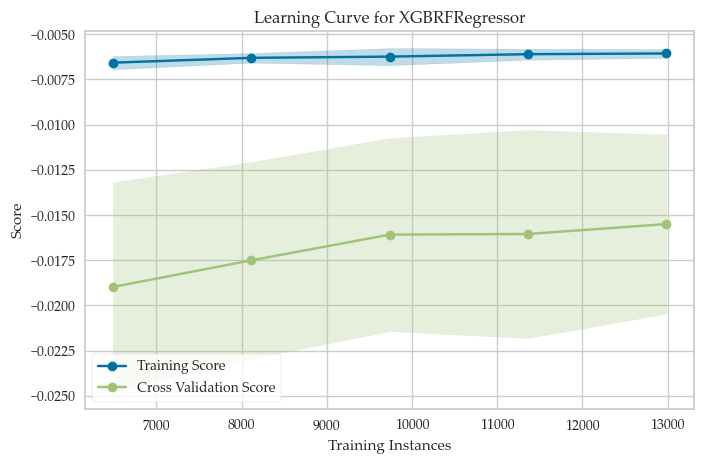

CPU times: total: 18min 38s
Wall time: 2min 26s


<AxesSubplot: title={'center': 'Learning Curve for XGBRFRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [32]:
%%time

# Plotting learning curve for XGBoost regressor
cv = ShuffleSplit(n_splits=5, random_state=random_state)
sizes = np.linspace(0.5, 1.0, 5)
plt.figure(figsize=(8,6))
visualizer = LearningCurve(XGBRF_best, 
                           cv=cv, 
                           scoring='neg_mean_absolute_percentage_error', 
                           train_sizes=sizes, n_jobs=-1, size=(720, 480))

visualizer.fit(X_std,y)

plt.title('Learning Curve for XGBRFRegressor')
plt.xlabel('Training Instances')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.savefig('pictures/Learning_Curve_for_XGBRFR.png', dpi = 300, transparent = True)
visualizer.show()

### PCA

In [33]:
%%time

start_time = time.time()
df_PCA_XGBRF_search = pd.DataFrame(columns=['r2_score', 'MSE', 'MAE', 'MAPE'])

for n in trange(5, X_train.shape[1], 2, desc=f"components progress"):
    pca = PCA(n_components=n)
    pca.fit(X_std)
    X_dec = pca.fit_transform(X_std)
    X_dec = pd.DataFrame(X_dec, columns=[f'component{i}' for i in range(n)])

    X_dec_train2, X_dec_test2, y_train, y_test = train_test_split(X_dec, y, test_size=0.2, random_state=random_state)
    
    XGBRF_grid = GridSearchCV(estimator=xgb.XGBRFRegressor(random_state=random_state, n_estimators=100),
                              param_grid=param_grid, 
                              verbose=0,
                              cv=ShuffleSplit(n_splits=n_splits, random_state=random_state),
                              #cv=n_splits,
                              )

    XGBRF_grid.fit(X_dec_train2, y_train)
    print(f"Best XGBRFRegressor-params for {n} components", XGBRF_grid.best_params_)
    
    XGBRF_best = XGBRF_grid.best_estimator_
    y_pred = XGBRF_best.predict(X_dec_test2)
    
    df_PCA_XGBRF_search.loc[n] = (r2_score(y_pred, y_test),
                                  MSE(y_pred, y_test), 
                                  MAE(y_pred, y_test),
                                  MAPE(y_pred, y_test))

elapsed_time = time.time() - start_time

n = df_PCA_XGBRF_search.MAPE.idxmin()  # get optimal count component

components progress:   0%|          | 0/10 [00:00<?, ?it/s]

Best XGBRFRegressor-params for 5 components {'max_depth': 15}
Best XGBRFRegressor-params for 7 components {'max_depth': 15}
Best XGBRFRegressor-params for 9 components {'max_depth': 15}
Best XGBRFRegressor-params for 11 components {'max_depth': 15}
Best XGBRFRegressor-params for 13 components {'max_depth': 15}
Best XGBRFRegressor-params for 15 components {'max_depth': 15}
Best XGBRFRegressor-params for 17 components {'max_depth': 15}
Best XGBRFRegressor-params for 19 components {'max_depth': 15}
Best XGBRFRegressor-params for 21 components {'max_depth': 15}
Best XGBRFRegressor-params for 23 components {'max_depth': 15}
CPU times: total: 44min 31s
Wall time: 5min 47s


In [34]:
search_result.loc[f'XGBRF+PCA({n})'] = (df_PCA_XGBRF_search.loc[n].r2_score,
                                        df_PCA_XGBRF_search.loc[n].MSE,
                                        df_PCA_XGBRF_search.loc[n].MAE,
                                        df_PCA_XGBRF_search.loc[n].MAPE,
                                        elapsed_time/(len(ParameterGrid(param_grid))*
                                                      n_splits*len(range(5, X_train.shape[1], 2))))
print(f'PCA {n} components',
      f'r2_score: {df_PCA_XGBRF_search.loc[n].r2_score:.4}',
      f'MSE: {df_PCA_XGBRF_search.loc[n].MSE:.4}',
      f'MAE: {df_PCA_XGBRF_search.loc[n].MAE:.4}',
      f'MAPE: {df_PCA_XGBRF_search.loc[n].MAPE:.2%}', sep='\n')

PCA 13 components
r2_score: 0.9952
MSE: 1.582
MAE: 0.336
MAPE: 1.55%


In [35]:
df_PCA_XGBRF_search

,r2_score,MSE,MAE,MAPE
5,0.994645,1.761857,0.335008,0.017154
7,0.994774,1.717370,0.339286,0.016259
9,0.994802,1.707939,0.343695,0.016932
11,0.994781,1.714091,0.347668,0.015978
13,0.995183,1.581803,0.335986,0.015472
15,0.995043,1.628603,0.337012,0.015732
17,0.995470,1.487776,0.328317,0.016063
19,0.995303,1.542732,0.332281,0.017067
21,0.995206,1.575735,0.326821,0.016096
23,0.995454,1.494604,0.321895,0.016610


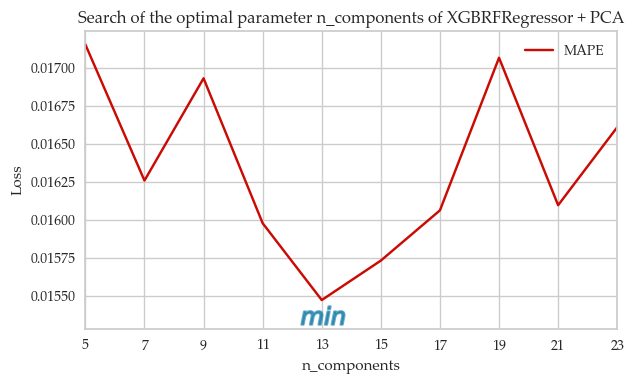

In [36]:
# plot search of the optimal parameter n_components of PCA
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
#plt.plot(df_PCA_XGBRF_search.index, df_PCA_XGBRF_search.MAE, 'b', label='MAE')
plt.plot(df_PCA_XGBRF_search.index, df_PCA_XGBRF_search.MAPE, 'r', label='MAPE')
plt.xlabel('n_components')
plt.xlim(left=5, right=23)
plt.xticks(ticks=np.arange(5, X_train.shape[1], step=2))
plt.ylabel('Loss')
plt.legend()
plt.title('Search of the optimal parameter n_components of XGBRFRegressor + PCA')

plt.scatter(df_PCA_XGBRF_search.MAPE.idxmin(), 
            df_PCA_XGBRF_search.MAPE.min()-0.0001,
            linewidth=1.5,
            marker='$min$',
            alpha=0.6,
            s=1000)

plt.tight_layout()
plt.savefig('pictures/PCA_XGBRF_search.png', dpi = 300, transparent = True)
plt.show()

## Multi Layer Perceptron

In [37]:
n_splits=5

param_grid={'hidden_layer_sizes': [(i, i) for i in range(5, 50, 5)],
            'activation': ['relu', 'tanh', 'logistic'],
           }

This model is built according to the methodology described in the [article](https://www.mdpi.com/1996-1944/15/21/7760, "Performance Analysis of Anode-Supported Solid Oxide Fuel Cells: A Machine Learning Approach")

### default (full set)

In [38]:
%%time

start_time = time.time()
    
MLP_grid = GridSearchCV(estimator=MLPRegressor(random_state=random_state, 
                                               learning_rate='invscaling',
                                               learning_rate_init=0.055,
                                               solver='adam',
                                               max_iter=2000),
                        param_grid=param_grid,
                        scoring='neg_mean_absolute_percentage_error', 
                        verbose=0,
                        cv=ShuffleSplit(n_splits=n_splits, random_state=random_state)
                       )
    
MLP_grid.fit(X_train, y_train)    
MLP_best = MLP_grid.best_estimator_
y_pred = MLP_best.predict(X_test)

elapsed_time = time.time() - start_time
    
print(f"Best MLP-params:", MLP_grid.best_params_)

Best MLP-params: {'activation': 'logistic', 'hidden_layer_sizes': (40, 40)}
CPU times: total: 6min 57s
Wall time: 5min 29s


In [39]:
search_result.loc['MLP default'] = (r2_score(y_pred, y_test),
                                    MSE(y_pred, y_test),
                                    MAE(y_pred, y_test),
                                    MAPE(y_pred, y_test),
                                    elapsed_time/(len(ParameterGrid(param_grid))*n_splits))
print('default MLP',
      f'r2_score: {r2_score(y_pred, y_test):.4}',
      f'MSE: {MSE(y_pred, y_test):.4}',
      f'MAE: {MAE(y_pred, y_test):.4}',
      f'MAPE: {MAPE(y_pred, y_test):.2%}', sep='\n')

default MLP
r2_score: 0.9947
MSE: 1.755
MAE: 0.5536
MAPE: 5.89%


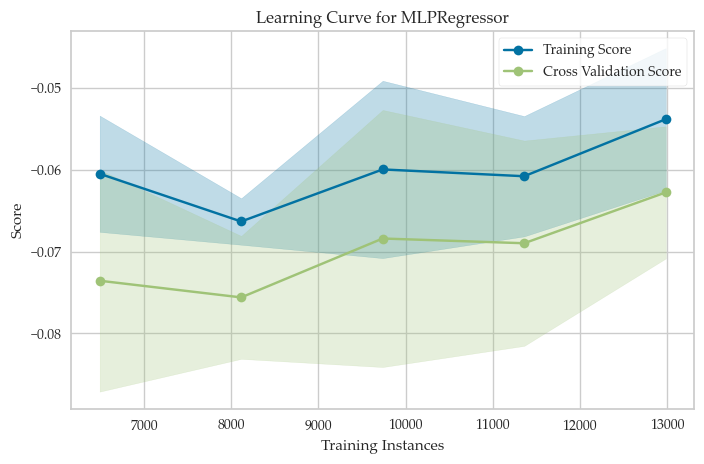

CPU times: total: 500 ms
Wall time: 35 s


<AxesSubplot: title={'center': 'Learning Curve for MLPRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [40]:
%%time

# Plotting learning curve for XGBoost regressor
cv = ShuffleSplit(n_splits=5, random_state=random_state)
sizes = np.linspace(0.5, 1.0, 5)
plt.figure(figsize=(8,6))
visualizer = LearningCurve(MLP_best, 
                           cv=cv, 
                           scoring='neg_mean_absolute_percentage_error', 
                           train_sizes=sizes, n_jobs=-1, size=(720, 480))

visualizer.fit(X_std,y)

plt.title('Learning Curve for MLPRegressor')
plt.xlabel('Training Instances')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.savefig('pictures/Learning_Curve_for_MLP.png', dpi = 300, transparent = True)
visualizer.show()

### PCA

In [41]:
%%time

start_time = time.time()
df_PCA_MLP_search = pd.DataFrame(columns=['r2_score', 'MSE', 'MAE', 'MAPE'])

for n in trange(5, X_train.shape[1], 2, desc=f"components progress"):
    pca = PCA(n_components=n)
    pca.fit(X_std)
    X_dec = pca.fit_transform(X_std)
    X_dec = pd.DataFrame(X_dec, columns=[f'component{i}' for i in range(n)])

    X_dec_train, X_dec_test, y_train, y_test = train_test_split(X_dec, y, test_size=0.2, random_state=random_state)
    
    MLP_grid = GridSearchCV(estimator=MLPRegressor(random_state=random_state, 
                                                   learning_rate='invscaling',
                                                   learning_rate_init=0.055,
                                                   solver='adam',
                                                   max_iter=2000),
                            param_grid=param_grid,
                            scoring='neg_mean_absolute_percentage_error',
                            verbose=0,
                            cv=ShuffleSplit(n_splits=n_splits, random_state=random_state)
                            )
    
    MLP_grid.fit(X_dec_train, y_train)
    print(f"Best MLP-params for {n} components", MLP_grid.best_params_)
    
    MLP_best = MLP_grid.best_estimator_
    y_pred = MLP_best.predict(X_dec_test)
    
    df_PCA_MLP_search.loc[n] = (r2_score(y_pred, y_test),
                                MSE(y_pred, y_test), 
                                MAE(y_pred, y_test),
                                MAPE(y_pred, y_test))

elapsed_time = time.time() - start_time

n = df_PCA_MLP_search.MAPE.idxmin()

components progress:   0%|          | 0/10 [00:00<?, ?it/s]

Best MLP-params for 5 components {'activation': 'logistic', 'hidden_layer_sizes': (35, 35)}
Best MLP-params for 7 components {'activation': 'logistic', 'hidden_layer_sizes': (35, 35)}
Best MLP-params for 9 components {'activation': 'tanh', 'hidden_layer_sizes': (40, 40)}
Best MLP-params for 11 components {'activation': 'logistic', 'hidden_layer_sizes': (10, 10)}
Best MLP-params for 13 components {'activation': 'tanh', 'hidden_layer_sizes': (40, 40)}
Best MLP-params for 15 components {'activation': 'tanh', 'hidden_layer_sizes': (45, 45)}
Best MLP-params for 17 components {'activation': 'tanh', 'hidden_layer_sizes': (30, 30)}
Best MLP-params for 19 components {'activation': 'logistic', 'hidden_layer_sizes': (20, 20)}
Best MLP-params for 21 components {'activation': 'tanh', 'hidden_layer_sizes': (40, 40)}
Best MLP-params for 23 components {'activation': 'logistic', 'hidden_layer_sizes': (15, 15)}
CPU times: total: 1h 3s
Wall time: 48min 14s


In [42]:
#search_result = search_result.head(8)

search_result.loc[f'MLP+PCA({n})'] = (df_PCA_MLP_search.loc[n].r2_score,
                                        df_PCA_MLP_search.loc[n].MSE,
                                        df_PCA_MLP_search.loc[n].MAE,
                                        df_PCA_MLP_search.loc[n].MAPE,
                                        elapsed_time/(len(ParameterGrid(param_grid))*
                                                      n_splits*len(range(5, X_train.shape[1], 2))))
print(f'PCA {n} components',
      f'r2_score: {df_PCA_MLP_search.loc[n].r2_score:.4}',
      f'MSE: {df_PCA_MLP_search.loc[n].MSE:.4}',
      f'MAE: {df_PCA_MLP_search.loc[n].MAE:.4}',
      f'MAPE: {df_PCA_MLP_search.loc[n].MAPE:.2%}', sep='\n')

PCA 23 components
r2_score: 0.9953
MSE: 1.555
MAE: 0.4896
MAPE: 4.82%


In [43]:
df_PCA_MLP_search

,r2_score,MSE,MAE,MAPE
5,0.990225,3.107470,0.951755,0.073854
7,0.990475,3.089149,0.949611,0.103816
9,0.990459,3.086941,0.872380,0.080273
11,0.990286,3.203902,0.822489,0.087897
13,0.992400,2.495885,0.674547,0.079925
15,0.992868,2.329355,0.636264,0.069176
17,0.993399,2.169694,0.642598,1.379478
19,0.940749,18.971171,3.386947,0.114713
21,0.994193,1.903012,0.625454,0.077299
23,0.995270,1.555273,0.489605,0.048182


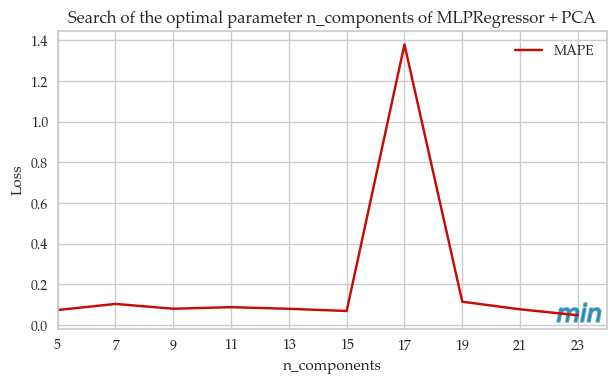

In [44]:
# plot search of the optimal parameter n_components of PCA
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
#plt.plot(df_PCA_MLP_search.index, df_PCA_MLP_search.MAE, 'b', label='MAE')
plt.plot(df_PCA_MLP_search.index, df_PCA_MLP_search.MAPE, 'r', label='MAPE')
plt.xlabel('n_components')
plt.xlim(left=5, right=24)
plt.xticks(ticks=np.arange(5, X_train.shape[1], step=2))
plt.ylabel('Loss')
plt.legend()
plt.title('Search of the optimal parameter n_components of MLPRegressor + PCA')

plt.scatter(df_PCA_MLP_search.MAPE.idxmin(), 
            df_PCA_MLP_search.MAPE.min()+0.015,
            linewidth=1.5,
            marker='$min$',
            alpha=0.6,
            s=1000)

plt.tight_layout()
plt.savefig('pictures/PCA_MLP_search.png', dpi = 300, transparent = True)
plt.show()

# Result

In [45]:
df_search_result = search_result.copy()

df_search_result = df_search_result.style.format({'R2_score': '{:.5f}', 
                                                  'MSE': '{:.4f}', 
                                                  'MAE': '{:.3f}',
                                                  'MAPE': '{:.2%}',
                                                  'seconds': '{:.6f}'
                                                 }).background_gradient(cmap=sns.color_palette("vlag", as_cmap=True))

#pd.set_option('display.float_format', lambda x: '%.6f' % x)
search_result.to_excel('search_result.xlsx', index=True)

df_search_result

,R2_score,MSE,MAE,MAPE,seconds
XGB default,0.99698,0.9940,0.309,2.63%,0.175746
XGB+PCA(19),0.99524,1.5670,0.392,3.52%,0.141196
XGB+SHAP(11),0.99660,1.1180,0.383,3.40%,0.108277
XGB+PI(11),0.99658,1.1234,0.384,3.40%,0.108657
XGB+MDI(11),0.99564,1.4293,0.410,3.54%,0.108386
XGBRF default,0.99680,1.0546,0.266,1.12%,3.190055
XGBRF+PCA(13),0.99518,1.5818,0.336,1.55%,2.319972
MLP default,0.99468,1.7546,0.554,5.89%,2.443948
MLP+PCA(23),0.99527,1.5553,0.490,4.82%,2.144259
